# Regression III

Neste módulo vamos avaliar aspectos estatísticos da análise de regressão. Vamos resgatar aspectos do teste de hipóteses à luz dos conceitos que vimos nos módulos anteriores de probabilidade e inferência, e vamos discutir as condições necessárias para valer esta inferência.

Objetivos:

- Inferência em regressão
    - Teste de hipóteses
    - Intervalo de confiança
    - Previsões sobre novas observações
    - Previsões sobre a média de y
- Linearizando relações não lineares
    - Transformações
    - Regressão segmentada
    - Lowess

In [3]:
# Bibliotecas

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

## 1 - Inferência em regressão

- Compreender a junção dos conceitos de probabilidade de diferença com modelos lineares
- Aprender a testar a relevância de um parâmetro em um modelo de regressão
- Praticar a criação de intervalos para parâmetros em regressão

##### Os dados

In [6]:
np.random.seed(1234)

nsample = 50
sig = .5
x = np.linspace(0, 20, nsample)
X = np.column_stack((x, np.sin(x), (x-5)**2, np.ones(nsample)))
beta = [.5, .5, -.02, 5.0]

y_true = np.dot(X, beta)
y = y_true + sig * np.random.normal(size=nsample)

df = pd.DataFrame(X, columns=['X1', 'X2', 'X3', 'Int'])
df['y'] = y
df['y_true'] = y_true
print(df.shape)
df.head()

(50, 6)


,X1,X2,X3,Int,y,y_true
0,0.000000,0.000000,25.000000,1.0,4.735718,4.500000
1,0.408163,0.396924,21.084965,1.0,4.385357,4.980844
2,0.816327,0.728635,17.503124,1.0,6.138772,5.422418
3,1.224490,0.940633,14.254477,1.0,5.641146,5.797472
4,1.632653,0.998087,11.339025,1.0,5.728295,6.088590


Text(0.5, 1.0, 'X1 vs Y')

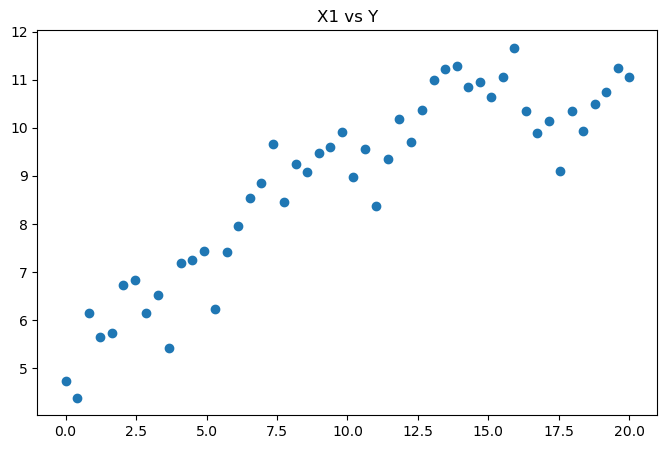

In [7]:
fig, ax = plt.subplots(figsize=[8,5])

ax.scatter(x=X[:,0], y=y, label='X1')
ax.set_title('X1 vs Y')

#### Inferência sobre $\beta$

Vamos retomar rapidamente a saída da análise de regressão do Statsmodels, agora à luz do que vimos em probabilidade e inferência. Vamos discutir a regressão linear simples (que tem só uma variável) apesar de a regressão múltipla (com mais de uma variável) ser bem mais popular, mas os resutlados que vamos discutir valem também para a regressão múltipla. 

No modelo de regressão tradicional temos que:

$Y \sim \mathcal{N}(\alpha + \beta X,\sigma^2_m)$

Na regressão linear simples, o estimador de mínimos quadrados de $\beta$ pode ser escrito assim:

$$ \hat{\beta} = \frac{\sum (X_i - \bar{X})(Y_i - \bar{Y})}{\sum (X_i - \bar{X})} $$

Esse estimador é basicamente uma função linear dos valores da variável resposta $Y_i's$. Considerando isto tempos os seguintes resultados:

- Os $y_i´s$ possuem distribuição Normal
- Combinações lineares de variáveis com distribuição Normal possuem também distribuição Normal
- Portanto, $\hat{\alpha}$ e $\hat{\beta}$ também possuem distribuição Normal.

Lembre-se que o $\hat{\beta}$ é uma função dos dados, portanto variável aleatória, portanto tem também uma distribuição. Não vamos entrar em detalhes profundos de como deduzir essa distribuição (o que pode ser encontrado em [Neter et. al. (2005)](#neter2005) ou outro livro de modelos lineares). Mas vamos usar esta distribuição, que está mostrada abaixo:

$$\hat{\beta} \sim \mathcal{N}\left(\beta, \sigma^2_\beta \right)$$
com $\sigma^2_\beta = \frac{\sigma^2}{\sum \left(X_i -\bar{X}\right)} $

O que significa que:

$$\frac{\hat{\beta} - \beta}{\sigma_\beta} \sim \mathcal{N}(0,1) $$

e que, substituindo $\sigma$ pelo seu estimador, que é o quadrado médio do resíduo (QME):

$$\frac{\hat{\beta} - \beta}{\hat{\sigma_\beta}} \sim \mathcal{T}(n-2) $$

com $\hat{\sigma_\beta} = \frac{QME}{\sum \left(X_i -\bar{X}\right)} = \frac{\frac{\sum(Y_i - \bar{Y})^2}{n-2}}{\sum \left(X_i -\bar{X}\right)}$

Com isto, podemos testar:

$H_0: \beta = 0$

$H_a: \beta \neq 0$


<br><br>
Logicamente, todos esses cálculos já estão implementados nos pacotes de regressão. O ponto deste texto é para vincular o que fizemos em inferência e o teste que está na análise de regressão, para entendermos o conceito: Se formularmos uma hipótese nula $H_0: \beta = 0$, podemos testá-la exatamente da mesma forma que fizemos em inferência. Mas o que significa $\beta = 0$? Significa que a variável $X$ correspondente não tem relação linear com Y - o que torna esse teste bastante interessante, por isso é bem padrão que esteja na maioria dos pacotes.

Vamos rodar na nossa base de exemplo.

In [9]:
# Aplicando a regressão

res = smf.ols('y ~ X1', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     191.5
Date:                Thu, 29 May 2025   Prob (F-statistic):           2.25e-18
Time:                        09:22:24   Log-Likelihood:                -64.035
No. Observations:                  50   AIC:                             132.1
Df Residuals:                      48   BIC:                             135.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9090      0.248     23.857      0.000       5.411       6.407
X1             0.2953      0.021     13.839      0.000       0.252       0.338
==============================================================================
Omnibus:                        3.070   Durbin-Watson:                   0.711
Prob(Omnibus):                  0.215   Jarque-Bera (JB):                2.023
Skew:                          -0.285   Prob(JB):                        0.364
Kurtosis:                       2.197   Cond. No.                         23.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
# Estatística "t" 

0.2953/0.021 # não obtemos o mesmo valor, pois aqui colocamos os aproximados

14.061904761904762

**Df Residuals** (*residual degrees of freedom*): Número de observações menos o números de parâmetros que estamos estimando. Aqui estamos estimando o intercepto e a inclinação.

Logo temos *Df Residuals* igual a 48, sendo o número de observações igual a 50.

Observe que todas as informações estão no objeto `res`, incluindo os próprios parâmetros.

In [13]:
res.params

Intercept    5.908971
X1           0.295330
dtype: float64

Eventualmente pode ser interessante acessar cada tabela do resumo com o método `res.summary()` separadamente.

In [15]:
resumo = res.summary()
resumo.tables[0]

Dep. Variable:,y,R-squared:,0.800
Model:,OLS,Adj. R-squared:,0.795
Method:,Least Squares,F-statistic:,191.5
Date:,"Thu, 29 May 2025",Prob (F-statistic):,2.25e-18
Time:,09:22:24,Log-Likelihood:,-64.035
No. Observations:,50,AIC:,132.1
Df Residuals:,48,BIC:,135.9
Df Model:,1,,
Covariance Type:,nonrobust,,


In [16]:
resumo.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.9090,0.248,23.857,0.000,5.411,6.407
X1,0.2953,0.021,13.839,0.000,0.252,0.338


In [17]:
resumo.tables[2]

Omnibus:,3.070,Durbin-Watson:,0.711
Prob(Omnibus):,0.215,Jarque-Bera (JB):,2.023
Skew:,-0.285,Prob(JB):,0.364
Kurtosis:,2.197,Cond. No.,23.0


#### Intervalo de confiança *beta*

O intervalo de confiança é uma estimativa para o parâmetro (o $\beta$ no caso) que contempla a sua incerteza amostral. O intervalo de confiança está relacionado com o teste de sifnigicância. A confiança é denotada pela letra grega $\gamma$, que é o complementar da significância $\alpha$. Ou seja, $\gamma = 1 - \alpha$.

De uma forma bem simples, estando todas as suposições do modelo suficientemente atendidas, podemos dizer com $\gamma\%$ de confiança que o verdadeiro parâmetro está dentro do intevalo.

**Antes de coletar os dados**, podemos dizer que temos $\gamma\%$ de probavilidade de o verdadeiro parâmetro $\beta$ cair dentro do intervalo - ou melhor, o intervalo é que aparece com o parâmetro dentro, pois o parâmetro é uma constante desconhecida, e o intervalo é que é aleatório.

**Após coletar os dados** o intervalo está dado, e o parâmetro é uma constante desconhecida. Dito isto, conceitualmente não podemos falar mais em probabilidade, por isso falamos em confiança. Por isso temos $\gamma\%$ de confiança em afirmar que o parâmetro está dentro do intervalo. Por exemplo, com o clássico 95% de confiança, esperamos que a cada 20 afirmações dessas, estejamos errados em uma.

A construção do intervalo de confiança é a seguinte: obtemos a amplitude do intervalo a partir da densidade do estimador, de modo que a probabilidade de o estimador estar neste intervalo seja $\gamma\%$ (95% por exemplo). Então construímos um intervalo com esta amplitude, centrado no valor estimado do parâmetro.

In [19]:
resumo.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.9090,0.248,23.857,0.000,5.411,6.407
X1,0.2953,0.021,13.839,0.000,0.252,0.338


**Dica de formatação** 

Uma dica interessante é que podemos selecionar partes específicas desse output, transformar em objeto do Pandas e formatar com os conhecimentos que já temos de pandas, por exemplo o ```.style()```. Abaixo vamos fazer isso passo a passo.

A indexação básica seleciona a tabela desejada. No caso ```resumo.tables[1]``` vai pegar a tabela com os parâmetros e os testes.

In [21]:
resumo.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.9090,0.248,23.857,0.000,5.411,6.407
X1,0.2953,0.021,13.839,0.000,0.252,0.338


A forma mais fácil de transformar essa tabela em Data Frame (que eu conheço pelo menos) é usar o ```.to_html``` para convertê-la em HTML, em seguida usar a função ```pd.read_html()``` do pandas. Repare que essa função é feita para ler uma página de internet e encontrar as tabelas (no plural mesmo, mais de uma), e retornar uma lista com todas as tabelas da página. Por isso vamos precisar da indexação final indicando que queremos a primeira tabela (mesmo sendo a única).

E, vamos utilizar o ```.style``` do pandas para realçar os *p-values* menores que 5%, colocar vírgula como separador de decimal e 4 casas decimais.

In [23]:
from io import StringIO

In [24]:
dados = StringIO(resumo.tables[1].as_html())
dados

In [25]:
tabela = pd.read_html(dados, header=0, index_col=0)[0]
tabela.style.format(decimal=',', precision=4).highlight_between(
    right = .05,
    axis = 1,
    props = 'color:red',
    subset = 'P>|t|'
).set_properties(**{'background-color': '#ffffb3'}, subset=['[0.025', '0.975]'])

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,"5,9090","0,2480","23,8570","0,0000","5,4110","6,4070"
X1,"0,2953","0,0210","13,8390","0,0000","0,2520","0,3380"


## 2 - Inferência sobre Y

- Compreender a previsão por intervalo em regressão
- Aplicar o método 'Get prediction' para fazer previsões usando Python
- Analisar como melhorar o ajuste do modelo de regressão

Vamos fazer agora uma previsão **pontual** (aquela que já estamos acostumados) e uma previsão **por intervalo** que leva em conta, em alguma medida, o erro amostral da nossa estimativa.

**Recapitulando**

- Definimos a variável resposta ```y```
- Definimos as varáveis explicativas (apenas ```X1``` no caso)
- Trouxemos o objeto ```smf.ols()``` do statsmodels, indicando o modelo e os dados
- Aplicamos o método ```fit()``` para "treinar" o modelo
- No script abaixo, guardamos tudo isso na variável ```res```
- Em seguida podemos aplicar, por exemplo, o método ```res.predict``` para fazer previsões

In [28]:
# Fazendo a regressão

res = smf.ols('y ~ X1', data = df).fit()
res.predict(exog = df.tail(3))

47    11.574489
48    11.695032
49    11.815575
dtype: float64

### Incerteza sobra a estimativa $\hat{y}$

O modelo de regressão acima é formulado da seguinte maneira:

$$ y_i = \alpha + \beta_1.X_{1, i} + \epsilon{i} $$

com:

- $X_{1, i}$ são os valores da variável $X_1$ para cada um dos indivíduos $i$, com $i=1, 2,... n$. Uma vez observados, são considerados constantes. 
- $\alpha$ sendo uma constante (não é aleatória), e pode ser interpretada como o valor de $Y$ quando $X_1=0$ (mesmo que esta interpretação seja meramente teórica)
- $\beta_1$ é uma constante, e pode ser interpretada como "o aumento em $y$ para cada unidade incrementada em $X_1$ 
- $\epsilon_i$ é o resíduo, ou seja, a diferença entre o verdadeiro valor de $Y_i$ e o seu valor esperado dado pelo modelo $E(Y_i) = \alpha + \beta X_i$. Tem distribuição aleatória Normal, com média zero e uma variância do modelo $\sigma^2_m$.

<div>
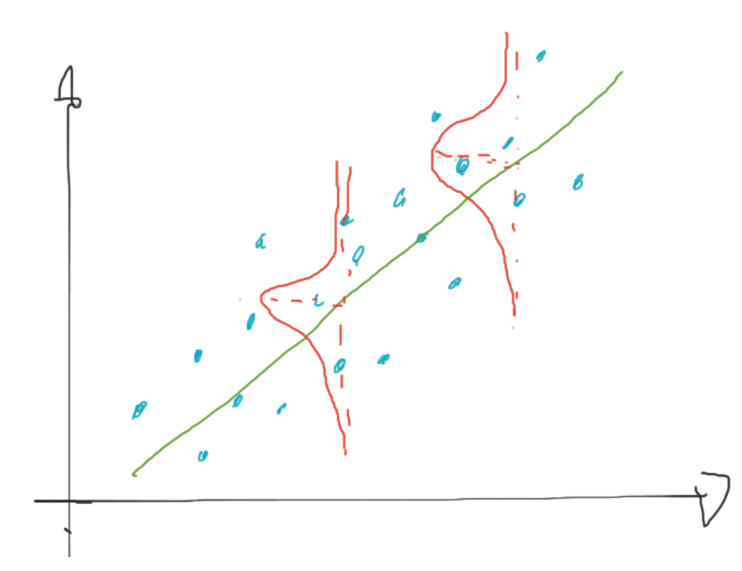
</div>

**Incertezas**

Tenha em mente que com esta estrutura do modelo de regressão, o valor de $y_j$ de uma nova observação *j* (não pertencente à amostra de treino), que é o que queremos prever, tem essa distribuição:

$$ y_j \sim N(\alpha + \beta x_1, \sigma^2_m) $$

De modo que se conhecermos $\alpha$ e $\beta$ (os parâmetros da regressão) mais o $\sigma^2_m$ (variância dos resíduos), podemos fazer toda a inferência convencional com a própria distribuição Normal sobre o $Y_j$.

No entanto, se queremos prever a média para uma nova observação, levando em conta o seu *erro padrão* (ou o "erro amostral"), vale ter em mente que essa previsão tem uma incerteza natural por conta da própria variância dos resíduos $\sigma^2_m$.

Vale também ressaltar que quando obtemos as estimativas dos parâmetros baseadas nos dados, os $\hat{\alpha}$ e $\hat{\beta}$, temos incerteza na estimativa dessas quantidades também.

Dessa forma, o erro amostral na previsão de uma nova observação vai depender do erro padrão de $\hat{\alpha} + \hat{\beta}x_i$ e vai depender também do $\hat{\sigma}^2_m$.

**IC da média e IC de uma nova observação**

Repare também que, quando estamos fazendo inferência sobre a média de $\hat{y}_i$, a parte que depende de $\sigma^2_m$ não é mais relevante, de modo que o erro padrão vai ser típicamente bem menor. Em geral os pacotes que realizam esse tipo de previsão possuem as duas formas disponíveis, no Python não é diferente - só precisamos saber qual queremos e a diferença entre elas.

**Como fazemos a previsão no Python?**

In [30]:
IC = res.get_prediction(exog = df.tail(3))
IC.summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,11.574489,0.232837,11.106338,12.042639,9.727035,13.421942
1,11.695032,0.240215,11.212046,12.178017,9.843763,13.546300
2,11.815575,0.247680,11.317580,12.313569,9.960334,13.670815


Temos a média, o erro padrão da média, limite e superior (lower and upper) inferior para o intervalo de confiança da média, limite inferior e superior para um intervalo de confiança de uma nova observação.

In [32]:
# Gerando um gráfico para os dados 

def esp_vs_obs(data=df):
    pred_ols = res.get_prediction()
    iv_l = pred_ols.summary_frame()['obs_ci_lower']
    iv_u = pred_ols.summary_frame()['obs_ci_upper']

    m_l = pred_ols.summary_frame()['mean_ci_lower']
    m_u = pred_ols.summary_frame()['mean_ci_upper']

    fig, ax = plt.subplots(figsize=[10,7])

    ax.plot(data.X1, data.y, 'o', label='Dados observados')
    ax.plot(data.X1, data.y_true, 'b-', label='Média da simulação')
    ax.plot(data.X1, res.fittedvalues, 'r--.', label='Estimativa OLS')
    ax.plot(data.X1, iv_u, 'r--', label='Banda de confiança para y')
    ax.plot(data.X1, iv_l, 'r--')
    ax.plot(data.X1, m_u,'g:', label='Banda de confiança para a média')
    ax.plot(data.X1, m_l, 'g:')
    ax.legend(loc='best')
    plt.show()

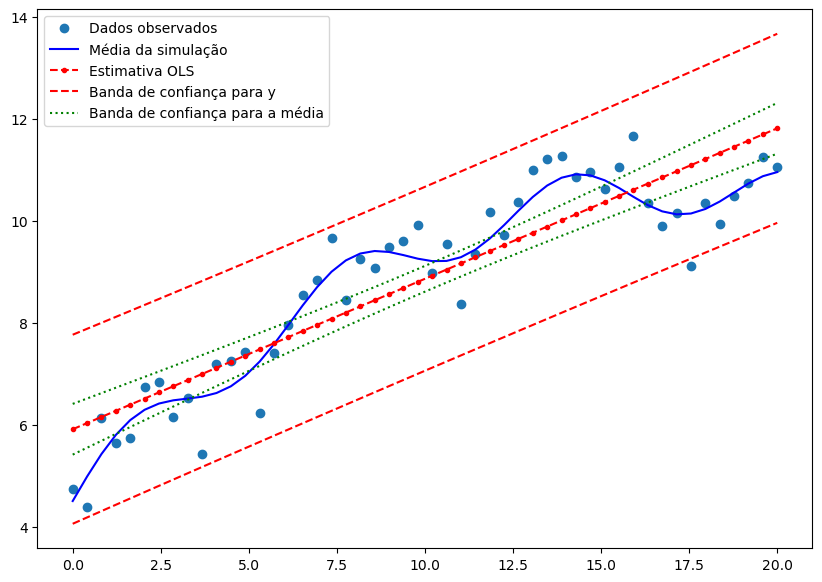

In [33]:
esp_vs_obs()

> É possível que 5% dos pontos estejam fora da banda de confiança para y, uma vez que o intervalo de confiança é de 95%.
> 
> O intervalo de confiança para a média, supondo que as variáveis tenham relação linear, contém a verdadeira média.


Como podemos ver a variável não tem relação linear com o y, há vários pontos fora do fitting, estamos perdendo informação. Como resolver isso?

## 3 - Linearizando relações não lineares

- Compreender técnicas para acomodar relações não lineares em modelos lineares
- Aplicar a técnica de categorização usando o pacote pandas em Python
- Avaliar a adequação do modelo e ajustar as categorias para melhorar o ajuste

A grande maioria dos problemas envolve dados bem representados por modelos lineares, **embora as relações de dependência possam ser não lineares**. Sim, é isso mesmo, através de transformações, muitas vezes simples simples (não lineares, é claro), podemos linearizar de forma bastante suficiente as relações entre as variáveis explicativas e a resposta.

Lembre-se:
- "Todo modelo está errado, mas alguns são úteis" como dizia George E. P. Box.


Vamos estudar agora formas de procurar linearizar relações não lineares. Vamos ver aqui as seguintes abordagens:

- **Categorização:** <br>
    Uma estratégia bem antiga e funcional consiste em transformar uma variável contínua em categorizada, modelando com *dummies* para cada categoria. Em crédito, essa estratégia é realizada desde os anos 70 (talvez antes) e até hoje é utilizada porque funciona. A vantagem da estratégia está no pragmatismo e simplicidade.

- **Aplicar transformações convencionais em X:**<br>
    Consiste em aplicar transformações como logaritmo, polinômios etc e buscar uma relação mais linear da variável explicativa com a resposta.

- **Regressão segmentada:**<br>
    Uma técnica bem interessante que consiste em definir um ponto de alteração da inclinação da reta de regressão.
    
- **Lowess:**<br>
    Uma técnica não paramêtrica que suavisa uma relação entre duas variáveis.

Representação das abordagens:
<div>
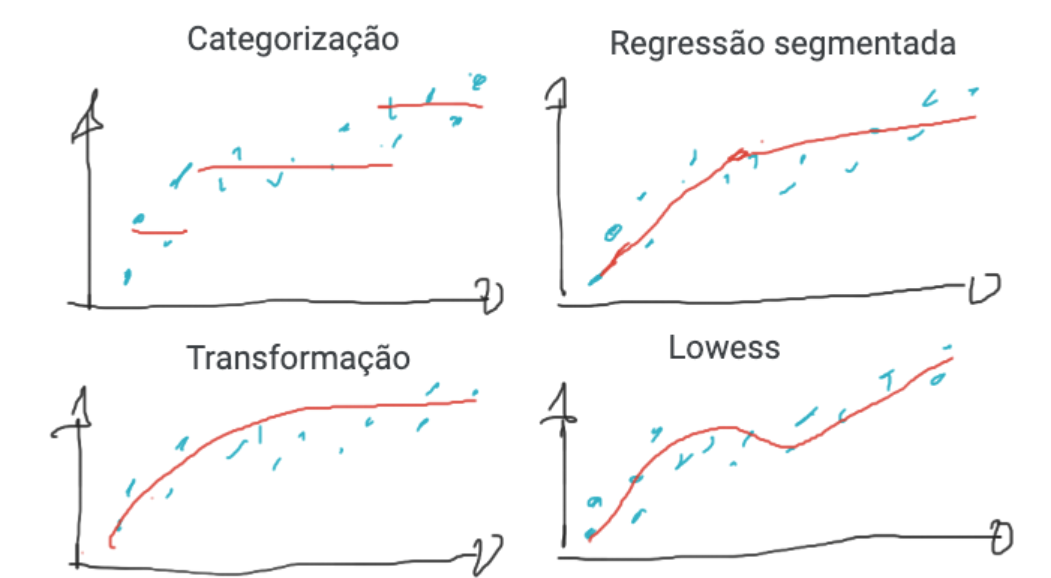
</div>


In [37]:
# Novamente a função 
def esp_vs_obs(data=df):
    pred_ols = res.get_prediction()
    iv_l = pred_ols.summary_frame()['obs_ci_lower']
    iv_u = pred_ols.summary_frame()['obs_ci_upper']

    m_l = pred_ols.summary_frame()['mean_ci_lower']
    m_u = pred_ols.summary_frame()['mean_ci_upper']

    fig, ax = plt.subplots(figsize=[8,6])

    ax.plot(data.X1, data.y, 'o', label='Dados observados')
    ax.plot(data.X1, data.y_true, 'b-', label='Média da simulação')
    ax.plot(data.X1, res.fittedvalues, 'r--.', label='Estimativa OLS')
    ax.plot(data.X1, iv_u, 'r--', label='Banda de confiança para y')
    ax.plot(data.X1, iv_l, 'r--')
    ax.plot(data.X1, m_u,'g:', label='Banda de confiança para a média')
    ax.plot(data.X1, m_l, 'g:')
    ax.legend(loc='best')
    plt.show()

In [38]:
# A regressão

res = smf.ols('y ~ X1', data=df).fit()
print(f'R-quadrado: {res.rsquared:.2%}')

R-quadrado: 79.96%


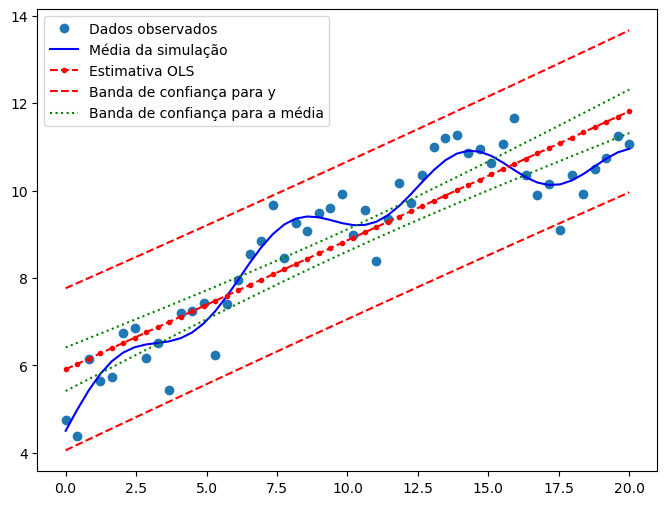

In [39]:
# Aplicando a função 

esp_vs_obs()

### Categorização

Uma ideia muito simples: categorizar a variável X e inserir as *dummies* de cada categoria. A estratégia tradicional consiste no seguinte:

1. Categorizar a variável por quantis (o ```pd.qcut()``` faz isso) em um número arbitrário, digamos, 10. Podemos usar mais grupos conforme o tamanho da amostra for maior.
2. Avaliar a média da variável resposta em cada grupo.
3. Agrupar os grupos que possuem a média da variável resposta muito parecida.

Vamos ver como podemos fazer isso no Pandas:

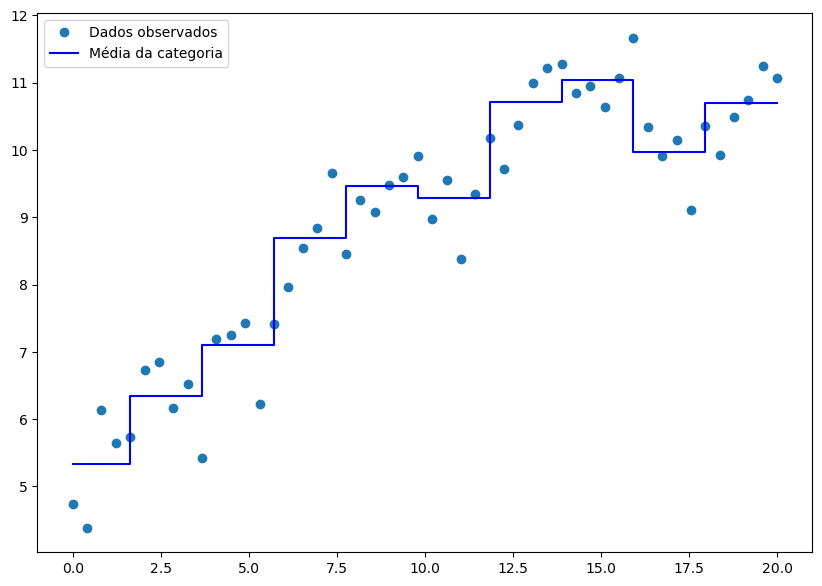

In [41]:
df['X1_cat'], quebras = pd.qcut(df.X1, 10, duplicates='drop', retbins=True)

y_med = pd.DataFrame()
y_med['y'] = df.groupby('X1_cat', observed=False)['y'].mean()
y_med['y_min'] = y_med.y - 2*df.groupby('X1_cat', observed=False)['y'].sem() #Return unbiased standard error of the mean over requested axis
y_med['y_max'] = y_med.y + 2*df.groupby('X1_cat', observed=False)['y'].sem()

y_med.rename(columns={'y': 'y_med'}, inplace=True)

tab = df.merge(y_med, on='X1_cat', how='left')

fig, ax = plt.subplots(figsize=[10,7])
ax.plot(tab.X1, tab.y, 'o', label='Dados observados', alpha=1)
ax.step(tab.X1, tab.y_med, 'b-', label='Média da categoria', alpha=1)
ax.legend()
plt.show()

In [42]:
# A tabela com os dados
tab.head()

,X1,X2,X3,Int,y,y_true,X1_cat,y_med,y_min,y_max
0,0.000000,0.000000,25.000000,1.0,4.735718,4.500000,"(-0.001, 2.0]",5.325857,4.669352,5.982363
1,0.408163,0.396924,21.084965,1.0,4.385357,4.980844,"(-0.001, 2.0]",5.325857,4.669352,5.982363
2,0.816327,0.728635,17.503124,1.0,6.138772,5.422418,"(-0.001, 2.0]",5.325857,4.669352,5.982363
3,1.224490,0.940633,14.254477,1.0,5.641146,5.797472,"(-0.001, 2.0]",5.325857,4.669352,5.982363
4,1.632653,0.998087,11.339025,1.0,5.728295,6.088590,"(-0.001, 2.0]",5.325857,4.669352,5.982363


##### Plotando novamente e inserindo o intervalo de confiança

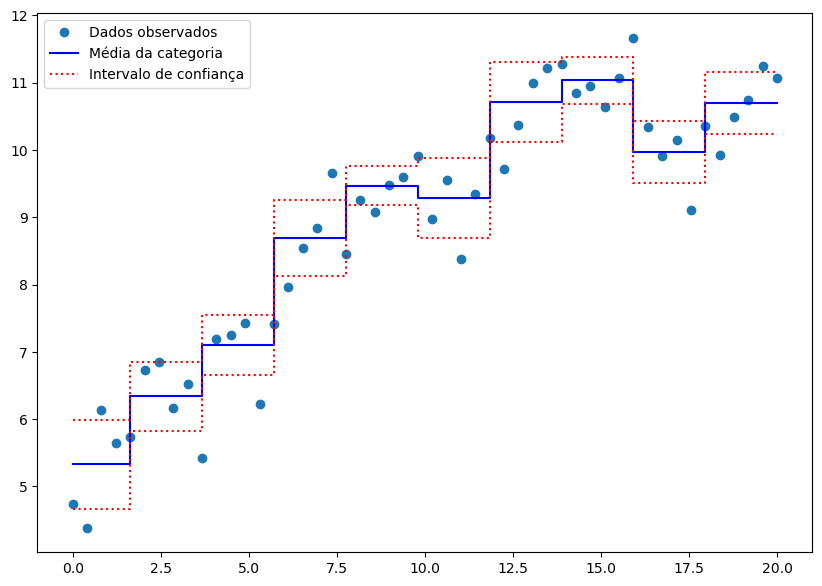

In [44]:
df['X1_cat'], quebras = pd.qcut(df.X1, 10, duplicates='drop', retbins=True)

y_med = pd.DataFrame()
y_med['y'] = df.groupby('X1_cat', observed=False)['y'].mean()
y_med['y_min'] = y_med.y - 2*df.groupby('X1_cat', observed=False)['y'].sem() #Return unbiased standard error of the mean over requested axis
y_med['y_max'] = y_med.y + 2*df.groupby('X1_cat', observed=False)['y'].sem()

y_med.rename(columns={'y': 'y_med'}, inplace=True)

tab = df.merge(y_med, on='X1_cat', how='left')

fig, ax = plt.subplots(figsize=[10,7])
ax.plot(tab.X1, tab.y, 'o', label='Dados observados', alpha=1)
ax.step(tab.X1, tab.y_med, 'b-', label='Média da categoria', alpha=1)
ax.step(tab.X1, tab.y_min, 'r:', label='Intervalo de confiança')
ax.step(tab.X1, tab.y_max, 'r:')
ax.legend()
plt.show()

##### Procedimento para agrupar categorias semelhantes

In [46]:
# as quebras que dividem as categorias (cada categoria possui 5 pontos)
quebras

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.])

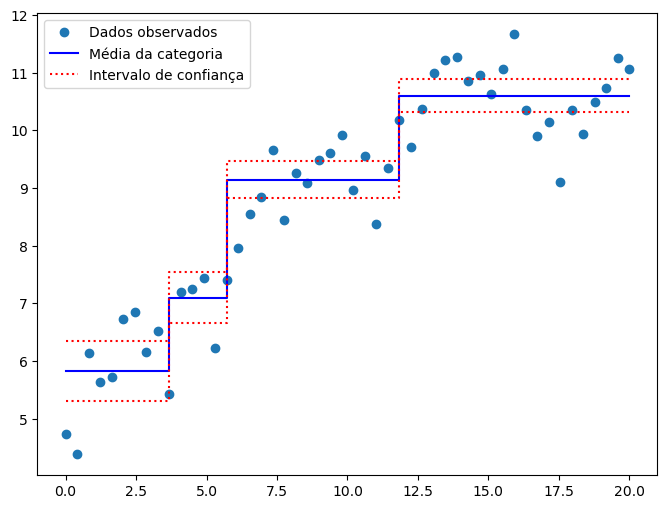

In [47]:
# Ajustando as categorias manualmente
quebras2 = [ -np.inf, 4.,  6., 12., 20.] 

df['X1_cat'] = pd.cut(df['X1'], bins=quebras2)

y_med = pd.DataFrame()
y_med['y_med'] = df.groupby('X1_cat', observed=False)['y'].mean()
y_med['y_min'] = y_med.y_med - 2*df.groupby('X1_cat', observed=False)['y'].sem()
y_med['y_max'] = y_med.y_med + 2*df.groupby('X1_cat', observed=False)['y'].sem()

tab = df.merge(y_med, on='X1_cat', how='left')

fig, ax = plt.subplots(figsize=[8,6])
ax.plot(tab.X1, tab.y, 'o', label='Dados observados', alpha=1)
ax.step(tab.X1, tab.y_med, 'b-', label='Média da categoria', alpha=1)
ax.step(tab.X1, tab.y_min, 'r:', label='Intervalo de confiança')
ax.step(tab.X1, tab.y_max, 'r:')
ax.legend()
plt.show()

In [48]:
df.head()

,X1,X2,X3,Int,y,y_true,X1_cat
0,0.000000,0.000000,25.000000,1.0,4.735718,4.500000,"(-inf, 4.0]"
1,0.408163,0.396924,21.084965,1.0,4.385357,4.980844,"(-inf, 4.0]"
2,0.816327,0.728635,17.503124,1.0,6.138772,5.422418,"(-inf, 4.0]"
3,1.224490,0.940633,14.254477,1.0,5.641146,5.797472,"(-inf, 4.0]"
4,1.632653,0.998087,11.339025,1.0,5.728295,6.088590,"(-inf, 4.0]"


R-quadrado: 89.43%


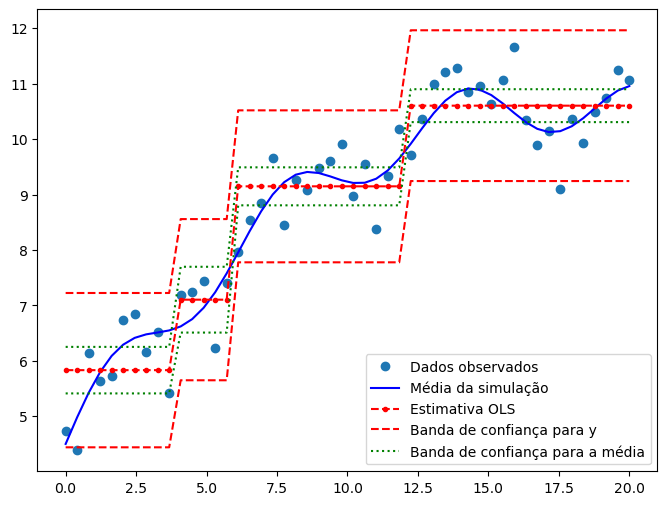

In [49]:
# Fazendo um modelo de regressão para os novos valores
# Com as categorias definidas

res = smf.ols('y ~ X1_cat', data=df).fit()
print(f'R-quadrado: {res.rsquared:.2%}')

# Chamando a função que definimos
esp_vs_obs()

## 4 - Transformação em x (aplicando transformações convencionais em x)

- Compreender o tratamento de relações não lineares através de categorização
- Aprender a realizar transformações em dados para melhorar o ajuste do modelo
- Entender o conceito e a aplicação da regressão segmentada


Uma abordagem bastante prática, popular e que traz interpretabilidade conveniente em muitos casos é utilizar uma transformação de X, como o logaritmo, expoente ou qualquer outra função que seja conveniente.

O pacote fórmula do `statsmodels` é muito prático para isso.

R-quadrado: 79.96%


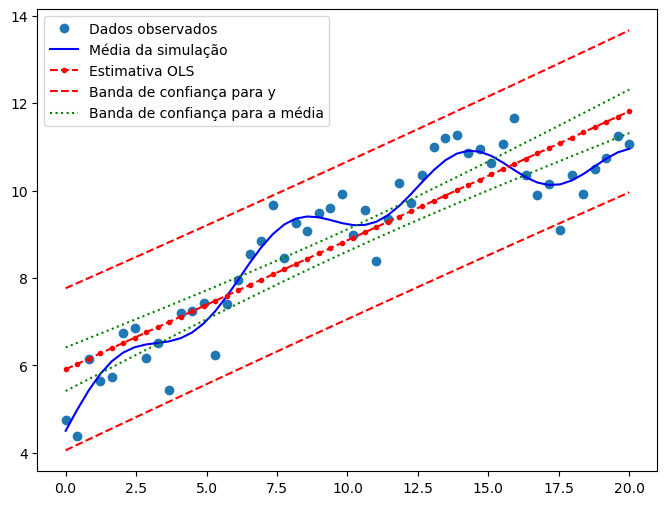

In [51]:
# Sem transformação

res = smf.ols('y ~ X1', data=df).fit()
print(f'R-quadrado: {res.rsquared:.2%}')

# Chamando a função de plot
esp_vs_obs()

In [52]:
df['log_X1'] = np.log(df.X1)
df.head()

C:\Users\duduj\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,X1,X2,X3,Int,y,y_true,X1_cat,log_X1
0,0.000000,0.000000,25.000000,1.0,4.735718,4.500000,"(-inf, 4.0]",-inf
1,0.408163,0.396924,21.084965,1.0,4.385357,4.980844,"(-inf, 4.0]",-0.896088
2,0.816327,0.728635,17.503124,1.0,6.138772,5.422418,"(-inf, 4.0]",-0.202941
3,1.224490,0.940633,14.254477,1.0,5.641146,5.797472,"(-inf, 4.0]",0.202524
4,1.632653,0.998087,11.339025,1.0,5.728295,6.088590,"(-inf, 4.0]",0.490206


In [53]:
# Como há um log de zero, temos como resposta -inf. 
# Vamos somar 1 para contornar esse problema, uma vez que o log(1)=0

df['log_X1'] = np.log(df.X1 + 1)
df.head()

,X1,X2,X3,Int,y,y_true,X1_cat,log_X1
0,0.000000,0.000000,25.000000,1.0,4.735718,4.500000,"(-inf, 4.0]",0.000000
1,0.408163,0.396924,21.084965,1.0,4.385357,4.980844,"(-inf, 4.0]",0.342286
2,0.816327,0.728635,17.503124,1.0,6.138772,5.422418,"(-inf, 4.0]",0.596816
3,1.224490,0.940633,14.254477,1.0,5.641146,5.797472,"(-inf, 4.0]",0.799528
4,1.632653,0.998087,11.339025,1.0,5.728295,6.088590,"(-inf, 4.0]",0.967992


R-quadrado: 87.25%


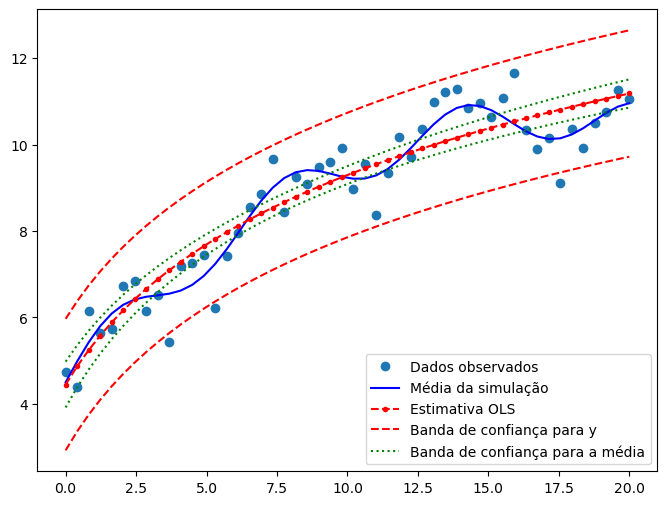

In [54]:
# Aplicando uma transformação logarítmica
# usando o Patsy interno ao smf

res = smf.ols('y ~ np.log(X1+1)', data=df).fit()
# Podemos variar a constante e buscar o melhor valor 
# consequentemente o melhor modelo
res = smf.ols('y ~ np.log(X1+3)', data=df).fit()
print(f'R-quadrado: {res.rsquared:.2%}')

# Função de plot
esp_vs_obs()

R-quadrado 89.19%


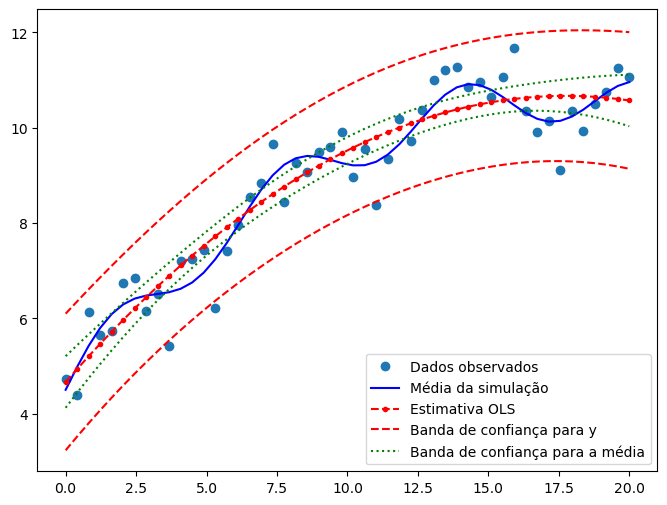

In [55]:
# Aplicando agora uma transformação para um polinômio de segundo grau

res = smf.ols('y ~ X1 + I(X1**2)', data=df).fit()
# res = smf.ols('y ~ X1 + np.power(X1, 2)', data=df).fit()
print(f'R-quadrado {res.rsquared:.2%}')

# Plot
esp_vs_obs()

R-quadrado: 94.11%


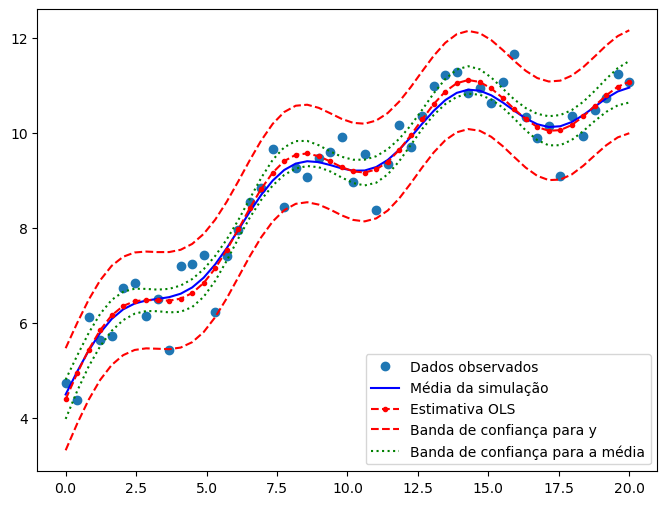

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     244.8
Date:                Thu, 29 May 2025   Prob (F-statistic):           2.79e-28
Time:                        09:22:27   Log-Likelihood:                -33.436
No. Observations:                  50   AIC:                             74.87
Df Residuals:                      46   BIC:                             82.52
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.3999      0.205     21.433      0.000       3.987       4.813
X1                  0.7298      0.047     15.454      0.000       0.635       0.825
np.power(X1, 2)    -0.0212      0.002     -9.342      0.000      -0.026      -0.017
np.sin(X1)          0.6303      0.102      6.195      0.000       0.425       0.835
==============================================================================
Omnibus:                        0.840   Durbin-Watson:                   2.269
Prob(Omnibus):                  0.657   Jarque-Bera (JB):                0.577
Skew:                          -0.263   Prob(JB):                        0.749
Kurtosis:                       2.972   Cond. No.                         551.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [56]:
# Uma vez que sabemos como os dados foram gerados, conhecemos sua estrutura. Podemos fazer

res = smf.ols('y ~ X1 + np.power(X1, 2) + np.sin(X1)', data=df).fit()
print(f'R-quadrado: {res.rsquared:.2%}')

# Plot
esp_vs_obs()

# Summary
res.summary()

## 5 - Regressão segmentada

- Compreender o conceito de regressão segmentada
- Implementar a regressão segmentada em um conjunto de dados
- Lidar com desafios comuns na análise de dados usando regressão segmentada.

Uma abordagem interessante para encontrar uma função de linearização de variáveis é a regressão segmentada. Com ela indicamos uma inclinação da reta para valores de $X$ menores que um certo valor de corte $C_0$, e uma outra inclinação para valores de $X$ maiores que esse valor de corte $C_0$.

<div>
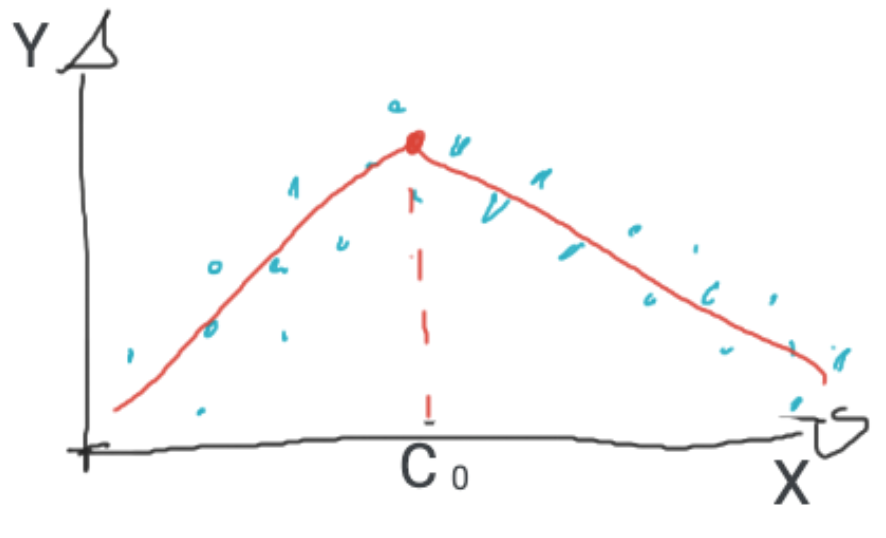
</div>

Para isto, criamos duas variáveis auxiliares $X_a$ e $X_b$ da seguinte forma:

$\begin{equation}
  X_a=\left\{
  \begin{array}{@{}ll@{}}
    X, & \text{se}\ X<=C_0 \\
    C_0, & \text{caso contrário}
  \end{array}\right.
\end{equation} $

$\begin{equation}
  X_b=\left\{
  \begin{array}{@{}ll@{}}
    0, & \text{se}\ X<=C_0 \\
    X-C_0, & \text{caso contrário}
  \end{array}\right.
\end{equation} $

<div>
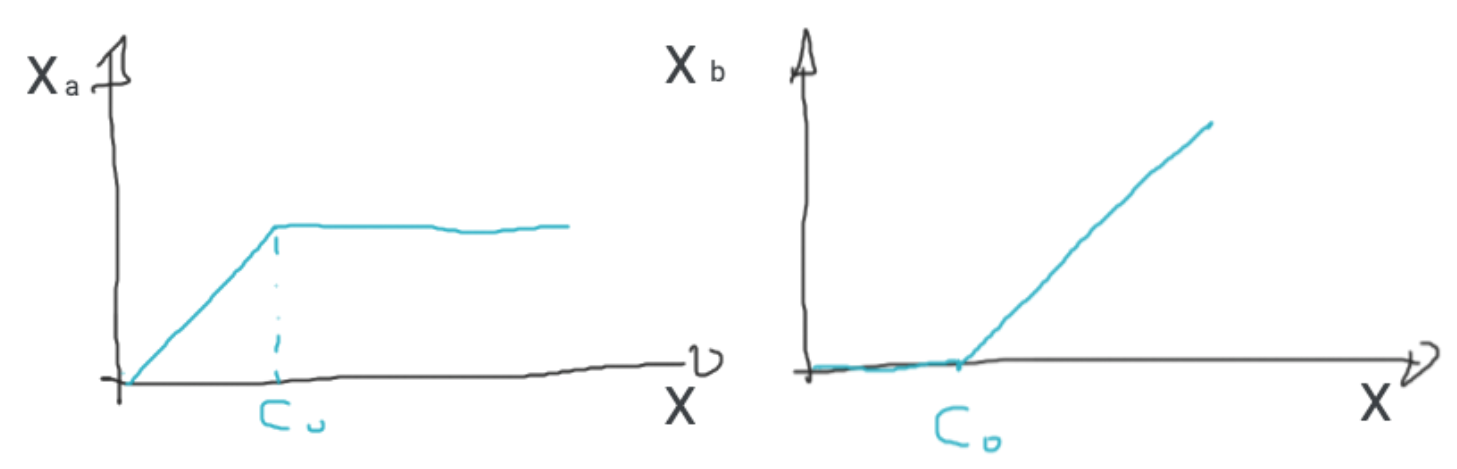
</div>


De modo que o modelo fica assim:

$Y = \alpha + \beta_1*X_a + \beta_2*X_b + \epsilon $

Repare que:
- Quando $X_a < C_0$ $X_b$ vai valer zero.
- Quando $X_a = C_0$ $X_b$ vai valer zero, e $X_a = C_0$.
- Quando $X_a > C_0$ $X_b$ vai valer $X - C_0$ e $X_a = C_0$.


In [59]:
# Aplicando a lógica da Regressão segmentada 

C1 = 13

df['X1_1'] = (df.X1<=C1)*df.X1 + (df.X1>C1)*C1
df['X1_2'] = (df.X1<=C1)*0 + (df.X1>C1)*(df.X1-C1)

df.head()

,X1,X2,X3,Int,y,y_true,X1_cat,log_X1,X1_1,X1_2
0,0.000000,0.000000,25.000000,1.0,4.735718,4.500000,"(-inf, 4.0]",0.000000,0.000000,0.0
1,0.408163,0.396924,21.084965,1.0,4.385357,4.980844,"(-inf, 4.0]",0.342286,0.408163,0.0
2,0.816327,0.728635,17.503124,1.0,6.138772,5.422418,"(-inf, 4.0]",0.596816,0.816327,0.0
3,1.224490,0.940633,14.254477,1.0,5.641146,5.797472,"(-inf, 4.0]",0.799528,1.224490,0.0
4,1.632653,0.998087,11.339025,1.0,5.728295,6.088590,"(-inf, 4.0]",0.967992,1.632653,0.0


R-quadrado: 89.67%


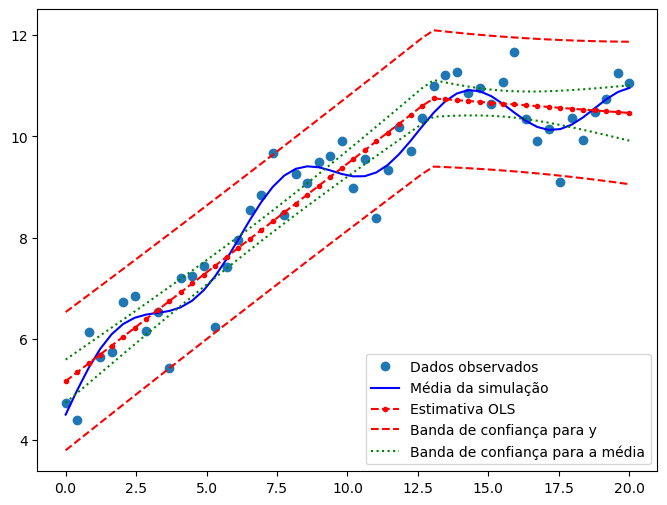

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     203.9
Date:                Thu, 29 May 2025   Prob (F-statistic):           6.84e-24
Time:                        09:22:27   Log-Likelihood:                -47.475
No. Observations:                  50   AIC:                             101.0
Df Residuals:                      47   BIC:                             106.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.1609      0.212     24.334      0.000       4.734       5.588
X1_1           0.4301      0.026     16.856      0.000       0.379       0.481
X1_2          -0.0414      0.053     -0.781      0.439      -0.148       0.065
==============================================================================
Omnibus:                        3.101   Durbin-Watson:                   1.360
Prob(Omnibus):                  0.212   Jarque-Bera (JB):                2.531
Skew:                          -0.551   Prob(JB):                        0.282
Kurtosis:                       3.039   Cond. No.                         23.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
# Aplicando a regressão

res = smf.ols('y ~ X1_1 + X1_2', data=df).fit()
print(f'R-quadrado: {res.rsquared:.2%}')

# Plot
esp_vs_obs()

# regressão saída
res.summary()

**Com base no p-value associado a `X1_2`, podemos rejeitar a hipótese nula ($H_{0}$), ou seja, podemos remover o valor de `X1_2` da regressão e ainda assim manter um bom modelo.**

Desta forma, obtemos:

R-quadrado: 89.53%


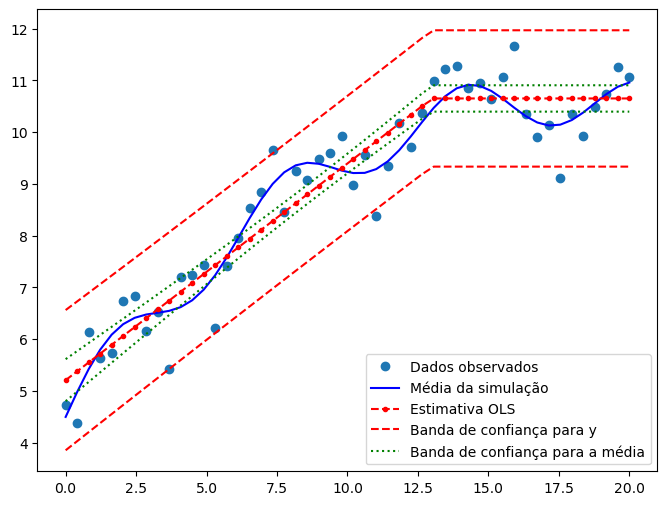

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     410.5
Date:                Thu, 29 May 2025   Prob (F-statistic):           3.62e-25
Time:                        09:22:27   Log-Likelihood:                -47.798
No. Observations:                  50   AIC:                             99.60
Df Residuals:                      48   BIC:                             103.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.2096      0.202     25.807      0.000       4.804       5.615
X1_1           0.4185      0.021     20.262      0.000       0.377       0.460
==============================================================================
Omnibus:                        3.044   Durbin-Watson:                   1.343
Prob(Omnibus):                  0.218   Jarque-Bera (JB):                2.501
Skew:                          -0.548   Prob(JB):                        0.286
Kurtosis:                       3.020   Cond. No.                         21.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
# removendo X1_2

res = smf.ols('y ~ X1_1', data=df).fit()
print(f'R-quadrado: {res.rsquared:.2%}')

# Plot
esp_vs_obs()

# regressão saída
res.summary()

### Regressão segmentada com 2 ou mais nós

Com três mudanças de inclinação, podemos especificar a regressão segmentada através dessas variáveis auxiliares conforme indicado abaixo. Para aumentar o número de 'nós' (ou mudanças de inclinação), basta definir mais pontos ($C_1, C_2, ... C_n$) e seguir a lógica abaixo.


$\begin{equation}
  X_a=\left\{
  \begin{array}{@{}ll@{}}
    X, & \text{se}\ X <= C_1 \\
    C_1, & \text{caso contrário}
  \end{array}\right.
\end{equation} $

$\begin{equation}
  X_b=\left\{
  \begin{array}{@{}ll@{}}
    0, & \text{se}\ X<=C_1 \\
    X-C_1, & \text{se } C_1<X<=C_2\\
    C_2-C_1, & \text{ caso contrário}
  \end{array}\right.
\end{equation} $

$\begin{equation}
  X_c=\left\{
  \begin{array}{@{}ll@{}}
    0, & \text{se}\ X<=C_2 \\
    X-C_2, & \text{caso contrário}
  \end{array}\right.
\end{equation} $

Graficamente temos as variáveis definidas assim:

<div>
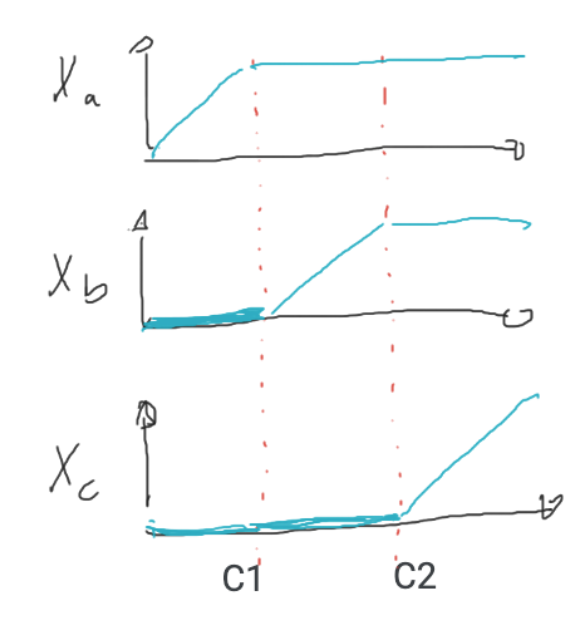
</div>

In [64]:
# Aplicando a segmentação para duas variáveis
C1 = 8
C2 = 15

df['X1_1'] = (df.X1<=C1)*df.X1 + (df.X1>C1)*C1
df['X1_2'] = (df.X1<=C1)*0 + ((df.X1>C1) & (df.X1<=C2)) * (df.X1-C1) + (df.X1>C2)*(C2-C1)
df['X1_3'] = (df.X1<=C2)*0 + (df.X1>C2)*(df.X1-C2)

df.head()

,X1,X2,X3,Int,y,y_true,X1_cat,log_X1,X1_1,X1_2,X1_3
0,0.000000,0.000000,25.000000,1.0,4.735718,4.500000,"(-inf, 4.0]",0.000000,0.000000,0.0,0.0
1,0.408163,0.396924,21.084965,1.0,4.385357,4.980844,"(-inf, 4.0]",0.342286,0.408163,0.0,0.0
2,0.816327,0.728635,17.503124,1.0,6.138772,5.422418,"(-inf, 4.0]",0.596816,0.816327,0.0,0.0
3,1.224490,0.940633,14.254477,1.0,5.641146,5.797472,"(-inf, 4.0]",0.799528,1.224490,0.0,0.0
4,1.632653,0.998087,11.339025,1.0,5.728295,6.088590,"(-inf, 4.0]",0.967992,1.632653,0.0,0.0


R-quadrado: 90.21%


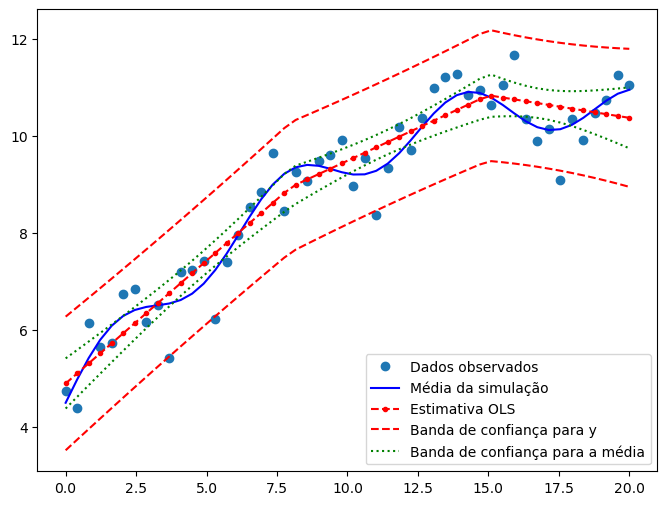

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     141.2
Date:                Thu, 29 May 2025   Prob (F-statistic):           3.24e-23
Time:                        09:22:28   Log-Likelihood:                -46.134
No. Observations:                  50   AIC:                             100.3
Df Residuals:                      46   BIC:                             107.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.8987      0.257     19.063      0.000       4.381       5.416
X1_1           0.5068      0.048     10.641      0.000       0.411       0.603
X1_2           0.2701      0.049      5.528      0.000       0.172       0.369
X1_3          -0.0932      0.087     -1.067      0.292      -0.269       0.083
==============================================================================
Omnibus:                        3.887   Durbin-Watson:                   1.442
Prob(Omnibus):                  0.143   Jarque-Bera (JB):                3.231
Skew:                          -0.621   Prob(JB):                        0.199
Kurtosis:                       3.092   Cond. No.                         22.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
# Aplicando a regressão
res = smf.ols('y ~ X1_1 + X1_2 + X1_3', data=df).fit()
print(f'R-quadrado: {res.rsquared:.2%}')

# Plot
esp_vs_obs()

# Sumário da regressão
res.summary()

**Com base no p-value, podemos descartar o ajuste `X1_3`.**

R-quadrado: 89.96%


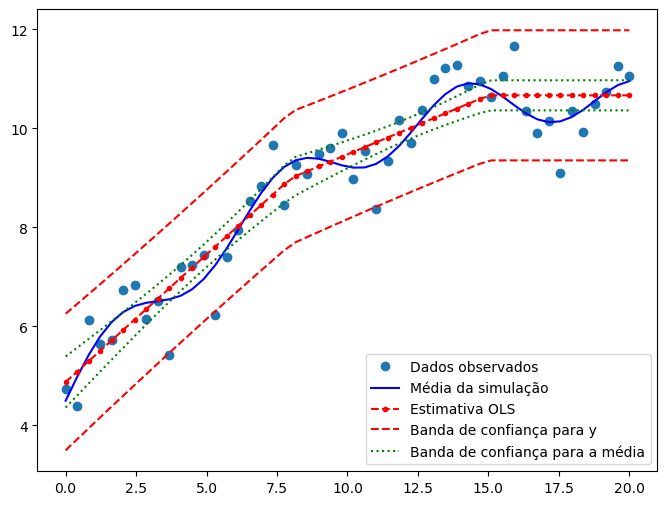

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     210.7
Date:                Thu, 29 May 2025   Prob (F-statistic):           3.44e-24
Time:                        09:22:28   Log-Likelihood:                -46.745
No. Observations:                  50   AIC:                             99.49
Df Residuals:                      47   BIC:                             105.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.8771      0.257     19.010      0.000       4.361       5.393
X1_1           0.5153      0.047     10.959      0.000       0.421       0.610
X1_2           0.2386      0.039      6.127      0.000       0.160       0.317
==============================================================================
Omnibus:                        3.821   Durbin-Watson:                   1.405
Prob(Omnibus):                  0.148   Jarque-Bera (JB):                3.130
Skew:                          -0.610   Prob(JB):                        0.209
Kurtosis:                       3.118   Cond. No.                         22.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
# Removendo X1_3
res = smf.ols('y ~ X1_1 + X1_2', data=df).fit()
print(f'R-quadrado: {res.rsquared:.2%}')

# Plot
esp_vs_obs()

# Sumário da regressão
res.summary()

### Linearização com muitas observações

Para o caso em que temos muitos dados, o gráfico de dispersão fica tipicamente pouco útil em dados reais. Assim, uma maneira de se conduzir a linearização da variável é...

In [69]:
np.random.seed(1234)

nsample2 = 50000
sig = .5
x2 = np.linspace(0, 20, nsample2)
X2 = np.column_stack((x2, np.sin(x2), (x2-5)**2, np.ones(nsample2)))
beta = [.5, .5, -.02, 5.0]

y_true2 = np.dot(X2, beta)
y2 = y_true2 + sig * np.random.normal(size=nsample2)

df2 = pd.DataFrame(X2, columns=['X1', 'X2', 'X3', 'Int'])
df2['y'] = y2
df2['y_true'] = y_true2
print(df2.shape)
df2.head()

(50000, 6)


,X1,X2,X3,Int,y,y_true
0,0.0000,0.0000,25.000000,1.0,4.735718,4.50000
1,0.0004,0.0004,24.996000,1.0,3.904992,4.50048
2,0.0008,0.0008,24.992000,1.0,5.217313,4.50096
3,0.0012,0.0012,24.988001,1.0,4.345114,4.50144
4,0.0016,0.0016,24.984002,1.0,4.141626,4.50192


In [70]:
# Visualização gráfica

def esp_vs_obs(data=df):
    pred_ols = res.get_prediction()
    iv_l = pred_ols.summary_frame()['obs_ci_lower']
    iv_u = pred_ols.summary_frame()['obs_ci_upper']

    m_l = pred_ols.summary_frame()['mean_ci_lower']
    m_u = pred_ols.summary_frame()['mean_ci_upper']

    fig, ax = plt.subplots(figsize=[10,7])

    ax.plot(data.X1, data.y, 'o', label='Dados observados', alpha=.8)
    ax.plot(data.X1, data.y_true, 'b-', label='Média da simulação')
    ax.plot(data.X1, res.fittedvalues, 'r--.', label='Estimativa OLS')
    ax.plot(data.X1, iv_u, 'r--', label='Banda de confiança para y')
    ax.plot(data.X1, iv_l, 'r--')
    ax.plot(data.X1, m_u,'g:', label='Banda de confiança para a média')
    ax.plot(data.X1, m_l, 'g:')
    ax.legend(loc='best')
    plt.show()

R-quadrado: 86.80%


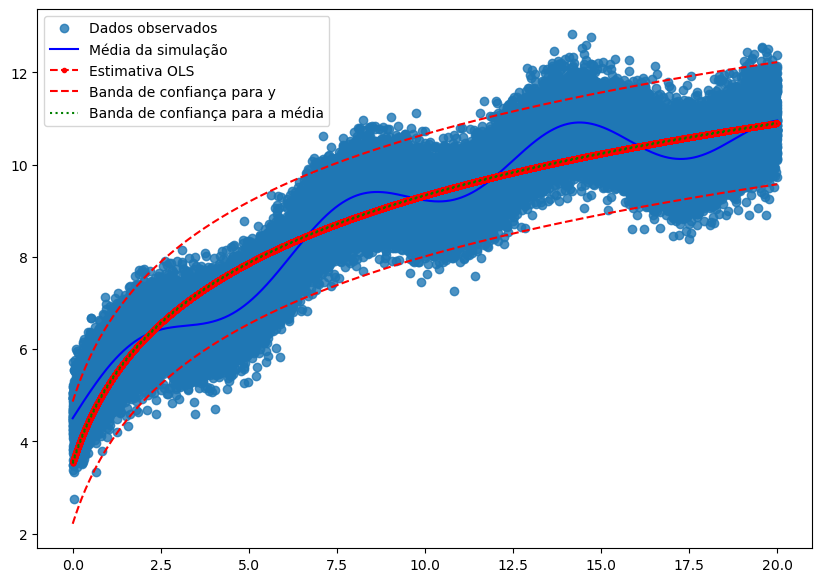

In [71]:
res = smf.ols('y ~ np.log(X1+1)', data=df2).fit()
print(f'R-quadrado: {res.rsquared:.2%}')

esp_vs_obs(data=df2)

**Para melhorar/facilitar a análise e visualização, façamos uma separação em categorias/grupos.**

In [73]:
grupos = pd.qcut(df2.X1, 20)

tab = df2.groupby(grupos, observed=False)['y'].describe()
tab['X1'] = df2.groupby(grupos, observed=False)['X1'].mean()
tab['y_true'] = df2.groupby(grupos, observed=False)['y_true'].mean()

tab.rename(columns={'mean':'y'}, inplace=True)
tab.head()

,count,y,std,min,25%,50%,75%,max,X1,y_true
X1,,,,,,,,,,
"(-0.001, 1.0]",2500.0,5.090855,0.592383,2.757099,4.693160,5.065630,5.497793,7.130920,0.49981,5.072973
"(1.0, 2.0]",2500.0,5.987838,0.537989,4.205059,5.628668,5.981165,6.368675,7.724454,1.49983,5.981442
"(2.0, 3.0]",2500.0,6.420529,0.499224,4.593426,6.088434,6.413398,6.763293,7.920263,2.49985,6.410223
"(3.0, 4.0]",2500.0,6.532815,0.504599,4.596712,6.203700,6.535357,6.869169,8.142275,3.49987,6.535145
"(4.0, 5.0]",2500.0,6.780667,0.519083,4.698613,6.434839,6.785910,7.140608,8.777703,4.49989,6.774635


<Axes: xlabel='X1', ylabel='y'>

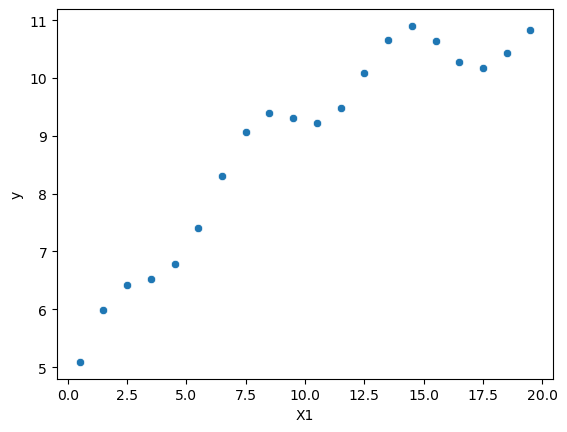

In [74]:
# Dessa forma resumimos os dados nas médias ao longo do x

sns.scatterplot(data=tab, x='X1', y='y')

Buscaremos fitar o modelo na nova base (médias ao longo do x).

R-quadrado: 87.45%


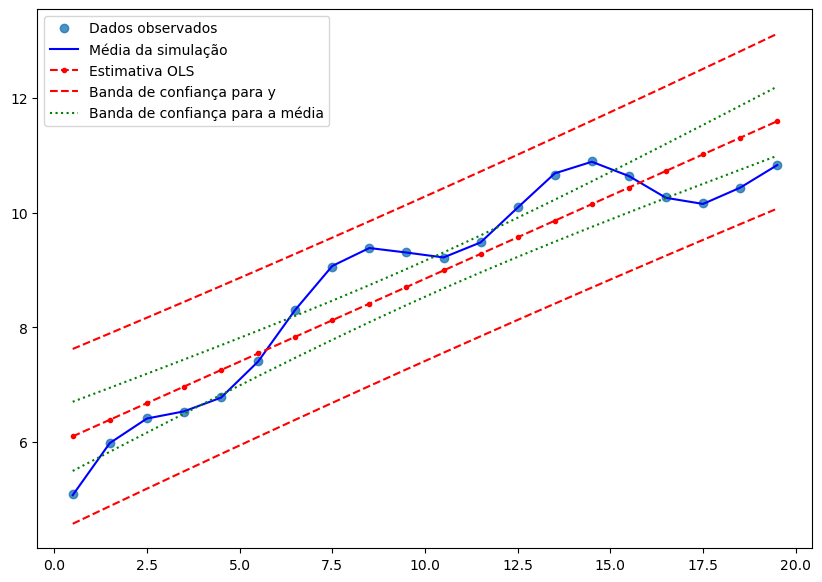

In [76]:
res = smf.ols('y ~ X1', data=tab).fit()
print(f'R-quadrado: {res.rsquared:.2%}')

esp_vs_obs(data=tab)

R-quadrado: 94.80%


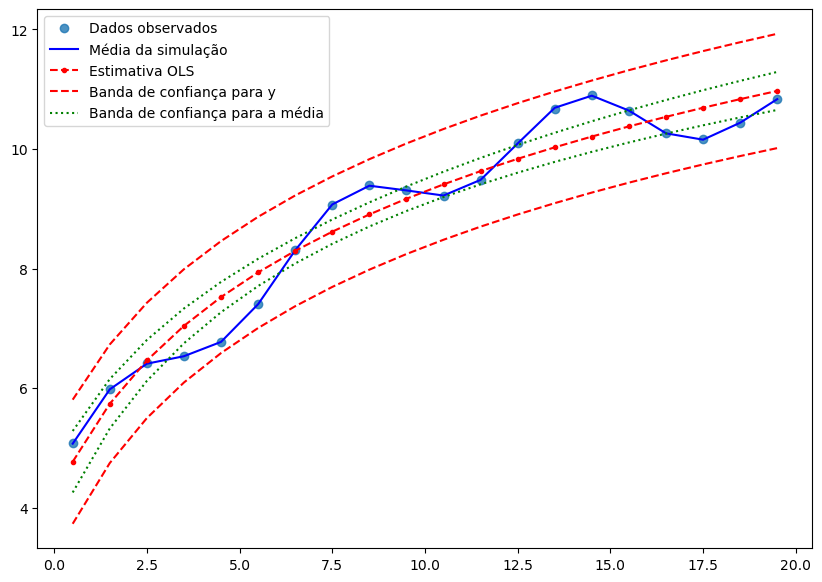

In [77]:
res = smf.ols('y ~ np.log(X1+2)', data=tab).fit()
print(f'R-quadrado: {res.rsquared:.2%}')

esp_vs_obs(data=tab)

> Vale lembrar que os valores de R-quadrado agora não são mais precisos, uma vez que cada ponto é uma média dentre muitos pontos.
>
> Os valores de R-quadrado explicam muito bem a variabilidade sobre as médias.


Para determinadas situações é importante truncar o valor em x, para evitar valores discrepantes.

## 6 - Lowess

- Compreender a técnica de Lowess e sua aplicação na suavização de dados
- Aplicar a função Lowess para ajustar um modelo usando o pacote scipy
- Interpretar os resultados obtidos através da técnica Lowess

Lowess significa "*Locally Weighted Scatterplot Smoothing*" (ou suavização de gráfico de dispersão localmente ponderada). É um método não-paramétrico, isto é, não assume distribuição de probabilidade específica para os dados, e encontra uma curva suave para Y dado cada valor de X. Essa função Y(X) "dá mais importância" para pontos próximos do X em questão, diminuindo rapidamente a importância para pontos mais longe.

Vamos ver o método de uma forma mais prática, mas para quem se interessar na matemática dele, estamos deixando alguns artigos nas referências mais abaixo.

In [81]:
import statsmodels.api as sm # A função do Lowess está aqui
from scipy.interpolate import interp1d # Vamos usar essa interpolação

array([[ 0.        ,  4.65325841],
       [ 0.40816327,  4.99166942],
       [ 0.81632653,  5.32114992],
       [ 1.2244898 ,  5.64529518],
       [ 1.63265306,  5.97056488],
       [ 2.04081633,  6.19397607],
       [ 2.44897959,  6.35768481],
       [ 2.85714286,  6.53995364],
       [ 3.26530612,  6.7136405 ],
       [ 3.67346939,  6.84960271],
       [ 4.08163265,  6.99698737],
       [ 4.48979592,  7.16870651],
       [ 4.89795918,  7.35863585],
       [ 5.30612245,  7.57040257],
       [ 5.71428571,  7.81255717],
       [ 6.12244898,  8.07411397],
       [ 6.53061224,  8.34286342],
       [ 6.93877551,  8.5968149 ],
       [ 7.34693878,  8.81376852],
       [ 7.75510204,  8.99999327],
       [ 8.16326531,  9.14242938],
       [ 8.57142857,  9.25654677],
       [ 8.97959184,  9.34380462],
       [ 9.3877551 ,  9.41080771],
       [ 9.79591837,  9.42848898],
       [10.20408163,  9.43707989],
       [10.6122449 ,  9.47479198],
       [11.02040816,  9.52865582],
       [11.42857143,

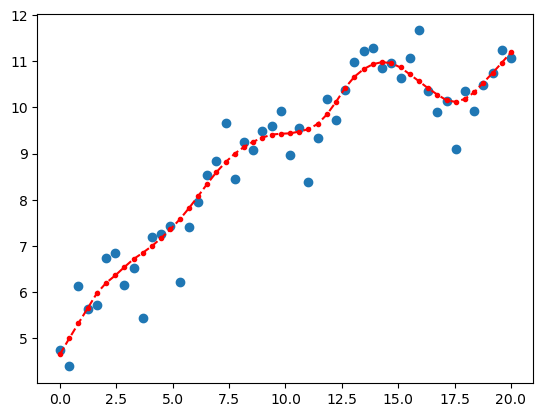

In [82]:
# Define a suavização dos dados na variável lowess
lowess = sm.nonparametric.lowess(df.y, df.X1, frac=1/5)

# Valores de y suavizados
lowess_y = lowess[:,1] # Pegando todas as linhas e a segunda coluna (y)

# Gráfico
fig, ax = plt.subplots()

ax.plot(df.X1, df.y, 'o', label='Dados observados', alpha=1)
ax.plot(df.X1, lowess_y, 'r--.', label='Lowess');

# os dados
lowess

##### Overfitting legal ajustando o hiperparâmetro

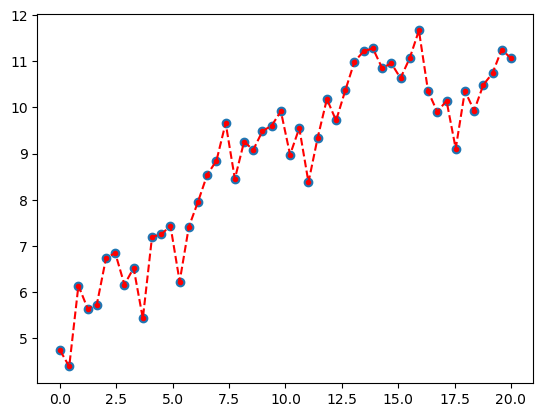

In [84]:
# Define a suavização dos dados na variável lowess
lowess = sm.nonparametric.lowess(df.y, df.X1, frac=1/20)

# Valores de y suavizados
lowess_y = lowess[:,1] # Pegando todas as linhas e a segunda coluna (y)

# Gráfico
fig, ax = plt.subplots()

ax.plot(df.X1, df.y, 'o', label='Dados observados', alpha=1)
ax.plot(df.X1, lowess_y, 'r--.', label='Lowess');

##### Utilizando o Lowess na regressão

Para tal utilizaremos uma interpolação

In [86]:
# Define a suavização dos dados na variável lowess
lowess = sm.nonparametric.lowess(df.y, df.X1, frac=1/5)
# Valores de y suavizados
lowess_y = lowess[:, 1] # Pegando todas as linhas e a segunda coluna (y)
lowess_x = lowess[:, 0] # Pegando todas as linhas e a segunda coluna (x)

In [87]:
# Roda a interpolação do scipy
f = interp1d(lowess_x, lowess_y, bounds_error=False)

df['X1_lowess'] = f(df.X1) # Armazena os pontos obtidos pelo Lowess
df.head()

,X1,X2,X3,Int,y,y_true,X1_cat,log_X1,X1_1,X1_2,X1_3,X1_lowess
0,0.000000,0.000000,25.000000,1.0,4.735718,4.500000,"(-inf, 4.0]",0.000000,0.000000,0.0,0.0,4.653258
1,0.408163,0.396924,21.084965,1.0,4.385357,4.980844,"(-inf, 4.0]",0.342286,0.408163,0.0,0.0,4.991669
2,0.816327,0.728635,17.503124,1.0,6.138772,5.422418,"(-inf, 4.0]",0.596816,0.816327,0.0,0.0,5.321150
3,1.224490,0.940633,14.254477,1.0,5.641146,5.797472,"(-inf, 4.0]",0.799528,1.224490,0.0,0.0,5.645295
4,1.632653,0.998087,11.339025,1.0,5.728295,6.088590,"(-inf, 4.0]",0.967992,1.632653,0.0,0.0,5.970565


R-quadrado: 93.50%


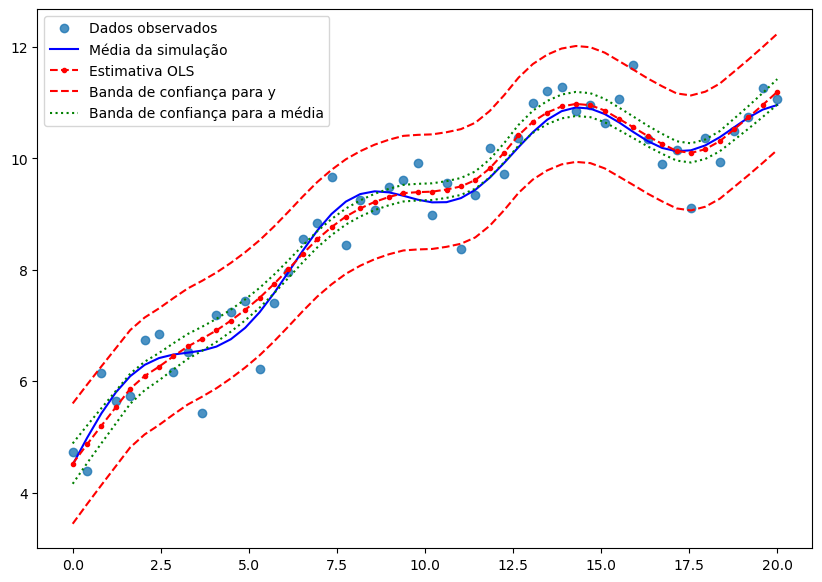

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     690.8
Date:                Thu, 29 May 2025   Prob (F-statistic):           3.79e-30
Time:                        09:22:30   Log-Likelihood:                -35.874
No. Observations:                  50   AIC:                             75.75
Df Residuals:                      48   BIC:                             79.57
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2297      0.353     -0.650      0.519      -0.940       0.481
X1_lowess      1.0205      0.039     26.283      0.000       0.942       1.099
==============================================================================
Omnibus:                        5.604   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.061   Jarque-Bera (JB):                4.582
Skew:                          -0.567   Prob(JB):                        0.101
Kurtosis:                       3.955   Cond. No.                         45.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [88]:
# A regressão

res = smf.ols('y ~ X1_lowess', data=df).fit()
print(f'R-quadrado: {res.rsquared:.2%}')

#Plot
esp_vs_obs()

# Sumário
res.summary()

R-quadrado: 89.09%


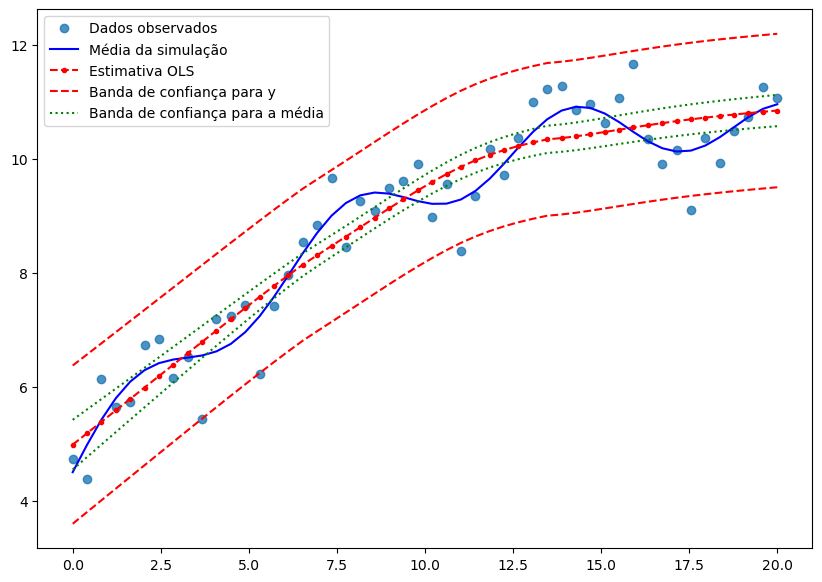

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     392.1
Date:                Thu, 29 May 2025   Prob (F-statistic):           9.73e-25
Time:                        09:22:30   Log-Likelihood:                -48.825
No. Observations:                  50   AIC:                             101.7
Df Residuals:                      48   BIC:                             105.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1146      0.463     -0.248      0.806      -1.045       0.816
X1_lowess      1.0168      0.051     19.801      0.000       0.914       1.120
==============================================================================
Omnibus:                        3.269   Durbin-Watson:                   1.296
Prob(Omnibus):                  0.195   Jarque-Bera (JB):                2.689
Skew:                          -0.568   Prob(JB):                        0.261
Kurtosis:                       3.041   Cond. No.                         45.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [89]:
# O que seria ideal, sem um ajuste muito grande

# Define a suavização dos dados na variável lowess
lowess = sm.nonparametric.lowess(df.y, df.X1, frac=2/3)
# Valores de y suavizados
lowess_y = lowess[:, 1] # Pegando todas as linhas e a segunda coluna (y)
lowess_x = lowess[:, 0] # Pegando todas as linhas e a segunda coluna (x)

# Roda a interpolação do scipy
f = interp1d(lowess_x, lowess_y, bounds_error=False)
df['X1_lowess'] = f(df.X1) # Armazena os pontos obtidos pelo Lowess

# A regressão

res = smf.ols('y ~ X1_lowess', data=df).fit()
print(f'R-quadrado: {res.rsquared:.2%}')
#Plot
esp_vs_obs()
# Sumário
res.summary()

R-quadrado: 100.00%


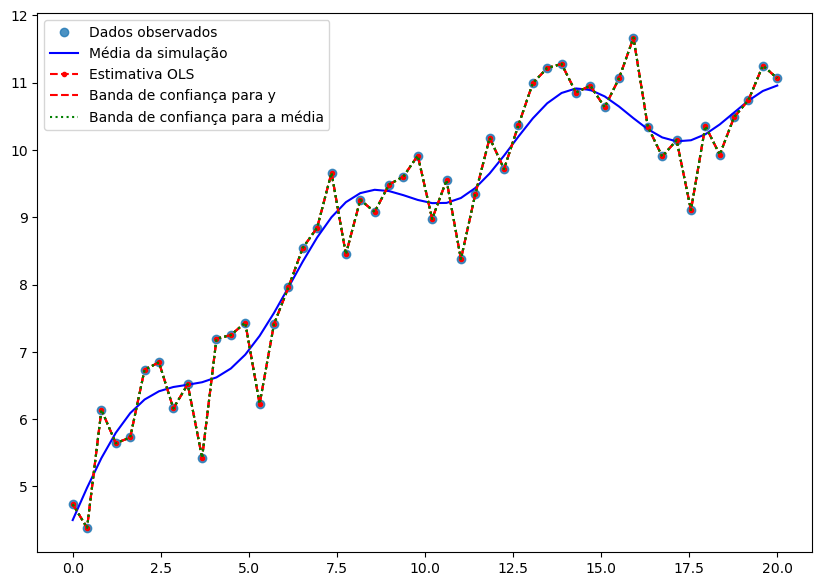

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.388e+30
Date:                Thu, 29 May 2025   Prob (F-statistic):               0.00
Time:                        09:22:30   Log-Likelihood:                 1568.0
No. Observations:                  50   AIC:                            -3132.
Df Residuals:                      48   BIC:                            -3128.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.665e-15   3.91e-15      0.426      0.672   -6.19e-15    9.52e-15
X1_lowess      1.0000   4.31e-16   2.32e+15      0.000       1.000       1.000
==============================================================================
Omnibus:                       10.812   Durbin-Watson:                   0.019
Prob(Omnibus):                  0.004   Jarque-Bera (JB):                2.997
Skew:                          -0.120   Prob(JB):                        0.223
Kurtosis:                       1.825   Cond. No.                         42.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [90]:
# Exagerando no overfitting a partir do hiperparâmetro (situação irreal)

# Define a suavização dos dados na variável lowess
lowess = sm.nonparametric.lowess(df.y, df.X1, frac=1/20)
# Valores de y suavizados
lowess_y = lowess[:, 1] # Pegando todas as linhas e a segunda coluna (y)
lowess_x = lowess[:, 0] # Pegando todas as linhas e a segunda coluna (x)

# Roda a interpolação do scipy
f = interp1d(lowess_x, lowess_y, bounds_error=False)
df['X1_lowess'] = f(df.X1) # Armazena os pontos obtidos pelo Lowess

# A regressão

res = smf.ols('y ~ X1_lowess', data=df).fit()
print(f'R-quadrado: {res.rsquared:.2%}')
#Plot
esp_vs_obs()
# Sumário
res.summary()